# Team Project #2 - Static Measures and Initial Uncertainty
## Dr. Pyrcz's Stochastic Method for Reservoir Modeling
## Team 4: Qiqi Wang, Jiachen Wang, Yanli pei, Honggeun Jo



## Objectives
### 1. Test the significance of the difference in the porosity and permeability by facies (Declustered)
        *Work Flow 
        1) Divide two facies
        2) t-test on porosity (by facies)
        3) F-test on porosity (by facies)
        4) t-test on log(permeability) (by facies)
        5) F-test on log(permeability) (by facies)
        6) Compare porosity and permeability by declustering
               
### 2. Provide an inital assessment of heterogeneity
        Is your reservoir homogeneous or heterogeneous?
        Use Coefficient of variation, Dykstra-Parsons and Lorenz (by facies)
### 3. Provide an initial uncertainty model for porosity and permeability and also facies proportions and OOIP (in bbls). 
        Assume thickness 20 m and oil saturation 90%
        
        *Work Flow 
        1) Declustered data
        2) Bootstrab for porosity
           - Sand/shale separately 
        3) Bootstrab for porosity
           - Sand/shale separately
        4) Bootstrab for facies proportion
        5) OOIP, Montecarlo simulation on facies ratio and corresponding porosities 
### 4. What would be the impact of another 10 wells on the uncertainty model?

# 0. Load package, initial setting, and fetching data

In [195]:
## Import needed package
import os                                                   # set current working directory 
import numpy as np                                          # ndarrays
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # plotting
from scipy import stats                                     # summary stats
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        
import seaborn as sns
import scipy.stats as st                               # statistical methods
import scipy.signal as signal             # kernel for moving window calculation
import random
import math  

## Set Working Directory
os.chdir("C:/Users/hj6488/Box Sync/04_Course work (Spring 2019)/200-Stoch Method for Reservoir Modeling/212 Team Project #2")  # set the working directory

# Load Data 
df = pd.read_csv("4_sample_data.csv")                       # well sample data
AI_map = np.loadtxt("4_AI.csv", delimiter = ",")            # AI map 

It seems that the first column seems not needed...

In [5]:
df.head()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
0,5,70,580,1,0.102475,30.149009,3477.934210
1,15,140,860,1,0.086987,8.540175,3500.807463
2,22,140,370,1,0.091117,266.893061,3478.303116
3,23,140,300,1,0.097404,5.483678,3428.434722
4,24,140,230,1,0.089087,29.146330,3853.554854


In [6]:
df_subset = df.iloc[:,1:7] 
df_subset.head()

,X,Y,Facies,Porosity,Perm,AI
0,70,580,1,0.102475,30.149009,3477.934210
1,140,860,1,0.086987,8.540175,3500.807463
2,140,370,1,0.091117,266.893061,3478.303116
3,140,300,1,0.097404,5.483678,3428.434722
4,140,230,1,0.089087,29.146330,3853.554854


In [7]:
print ("The number of well data sample is %.0f, \n and total number of reservoir cells are %.0f" % (df_subset.shape[0], AI_map.shape[0]*AI_map.shape[1]))

The number of well data sample is 178, 
 and total number of reservoir cells are 10000


In [17]:
# Define initial setting
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
pormin = 0.0; pormax = 0.2;             # range of porosity values
permmin = 0.01; permmax = 6000;
AImin = 1000.0; AImax = 5500
Fmin = 0; Fmax = 1

# 1.Difference between sand and shape (in porosity and permeability)

In [11]:
# Split data frame into two part based on their facies
df_sand=df_subset.loc[(df_subset['Facies']==1)]
df_shale=df_subset.loc[(df_subset['Facies']==0)]

In [13]:
df_sand.head()

,X,Y,Facies,Porosity,Perm,AI
0,70,580,1,0.102475,30.149009,3477.934210
1,140,860,1,0.086987,8.540175,3500.807463
2,140,370,1,0.091117,266.893061,3478.303116
3,140,300,1,0.097404,5.483678,3428.434722
4,140,230,1,0.089087,29.146330,3853.554854


## 1-1) Porosity

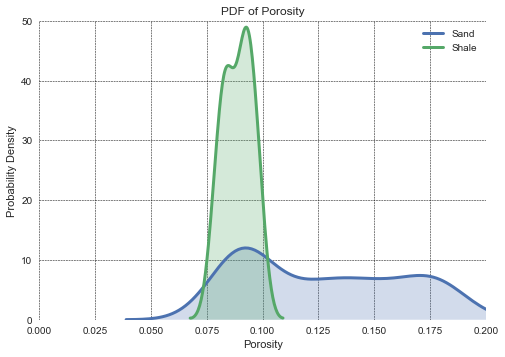

In [24]:
# Draw PDF of each facies
plt.clf()

sns.distplot(df_sand['Porosity'], hist = False, kde = True, kde_kws ={'shade': True, 'linewidth': 3}, label = 'Sand' )
sns.distplot(df_shale['Porosity'], hist = False, kde = True, kde_kws ={'shade': True, 'linewidth': 3}, label = 'Shale' )


plt.title('PDF of Porosity')
plt.xlabel('Porosity')
plt.ylabel('Probability Density')
plt.axis([pormin, pormax,0,50])
ax = plt.gca()
ax.set_facecolor('w')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.grid('on',color='k', linestyle='--', linewidth=0.5)


plt.show()
plt.savefig('PDF of Porosity by facies',dpi=600)

In [135]:
# t-test for check the difference of mean
t_value, p_value=stats.ttest_ind(df_sand['Porosity'].values,df_shale['Porosity'].values,equal_var = False)
alpha=0.05

print('t-test result: P-value is %.30f' %p_value)
if p_value < alpha/2:
    print ("Null hypothesis rejected")
    print ("Means of two sample are significantly different\n")
else:
    print ("Null hypothesis is failed to be rejected")
    print ("Means of two sample are not significantly different\n")

# F-test for check the difference of varience
if df_sand['Porosity'].values.var() > df_shale['Porosity'].values.var():
    F=df_sand['Porosity'].values.var()/df_shale['Porosity'].values.var()
else:
    F=df_shale['Porosity'].values.var()/df_sand['Porosity'].values.var()

dof_1=len(df_sand['Porosity'].values)-1; dof_2=len(df_shale['Porosity'].values)-1;
p_value = stats.f.cdf(F, dof_1, dof_2)

alpha=0.05

print('F-test result: P-value is %.30f' %(1-p_value))
if p_value > (1-alpha):
    print ("Null hypothesis rejected")
    print ("Variance of two sample are significantly different\n")

else:
    print ("Null hypothesis is failed to be rejected")
    print ("Variance of two sample are significantly different\n")

t-test result: P-value is 0.000000000000000000000002194629
Null hypothesis rejected
Means of two sample are significantly different

F-test result: P-value is 0.000000000011787126830142824474
Null hypothesis rejected
Variance of two sample are significantly different



Null hypothesis rejected

Variance of two sample are significantly different



## 1-2) Permeability

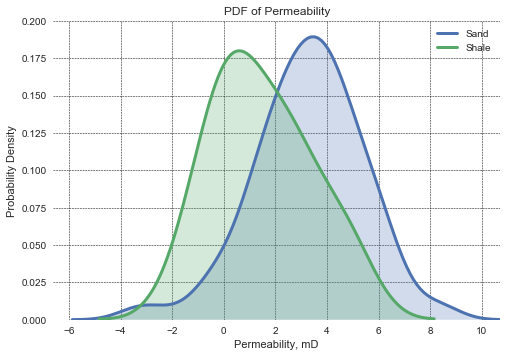

In [46]:
# Draw PDF of each facies
plt.clf()

sns.distplot(np.log(df_sand['Perm']), hist = False, kde = True, kde_kws ={'shade': True, 'linewidth': 3}, label = 'Sand' )
sns.distplot(np.log(df_shale['Perm']), hist = False, kde = True, kde_kws ={'shade': True, 'linewidth': 3}, label = 'Shale' )


plt.title('PDF of Permeability')
plt.xlabel('Permeability, mD')
plt.ylabel('Probability Density')
plt.axis([np.log(permmin)-2, np.log(permmax)+2,0,0.2])
ax = plt.gca()
ax.set_facecolor('w')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.grid('on',color='k', linestyle='--', linewidth=0.5)


plt.show()
plt.savefig('PDF of Permeability by facies',dpi=600)

In [136]:
# t-test for check the difference of mean
t_value, p_value=stats.ttest_ind(np.log(df_sand['Perm'].values),np.log(df_shale['Perm'].values),equal_var = False)
alpha=0.05

print('t-test result: P-value is %.30f' %p_value)
if p_value < alpha/2:
    print ("Null hypothesis is rejected")
    print ("Means of two sample are significantly different\n")
else:
    print ("Null hypothesis is failed to be rejected")
    print ("Means of two sample are not significantly different\n")

# F-test for check the difference of varience
if np.log(df_sand['Perm'].values).var() > np.log(df_shale['Perm'].values).var():
    F=np.log(df_sand['Perm'].values).var()/np.log(df_shale['Perm'].values).var()
else:
    F=np.log(df_shale['Perm'].values).var()/np.log(df_sand['Perm'].values).var()

dof_1=len(df_sand['Perm'].values)-1; dof_2=len(df_shale['Perm'].values)-1;
p_value = stats.f.cdf(F, dof_1, dof_2)

alpha=0.05

print('F-test result: P-value is %.30f' %(1-p_value))
if p_value > (1-alpha):
    print ("Null hypothesis is rejected")
    print ("Variance of two sample are significantly different\n")

else:
    print ("Null hypothesis is failed to be rejected")
    print ("Variance of two sample are not significantly different\n")

t-test result: P-value is 0.000581915353903311944119836063
Null hypothesis is rejected
Means of two sample are significantly different

F-test result: P-value is 0.243345022280759937238769907708
Null hypothesis is failed to be rejected
Variance of two sample are not significantly different



## 1-3) Decluster

In [172]:
wts_sand, cell_sizes_sand, dmeans_sand = geostats.declus(df_sand,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
wts_shale, cell_sizes_shale, dmeans_shale = geostats.declus(df_shale,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
wts, cell_sizes, dmeans = geostats.declus(df_subset,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)

df_sand['Wts'] = wts_sand  
df_shale['Wts'] = wts_shale
df_subset['Wts'] = wts  


There are 158 data with:
   mean of      0.126750289563 
   min and max  0.079210481 and 0.186311206
   standard dev 0.034889607528 
There are 20 data with:
   mean of      0.088845095 
   min and max  0.078601287 and 0.097991102
   standard dev 0.00620744758609 
There are 178 data with:
   mean of      0.122491278938 
   min and max  0.078601287 and 0.186311206
   standard dev 0.0350448297015 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [120]:
df_sand.head()

,X,Y,Facies,Porosity,Perm,AI,Wts
0,70,580,1,0.102475,30.149009,3477.934210,2.114246
1,140,860,1,0.086987,8.540175,3500.807463,1.263144
2,140,370,1,0.091117,266.893061,3478.303116,1.234876
3,140,300,1,0.097404,5.483678,3428.434722,1.272462
4,140,230,1,0.089087,29.146330,3853.554854,1.278381


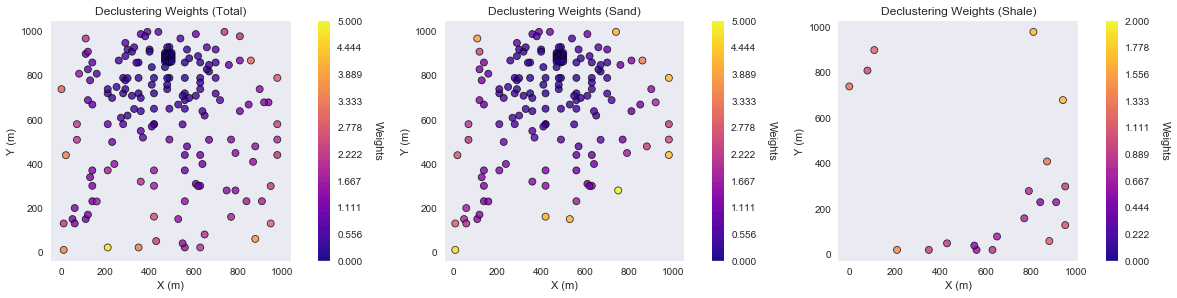

In [115]:
plt.figure(figsize=(20,15)) 

plt.subplot(331)
cmap = plt.cm.plasma                    # color map
GSLIB.locmap_st(df_subset,'X','Y','Wts',xmin,xmax,ymin,ymax,0.0,5.0,'Declustering Weights (Total)','X (m)','Y (m)','Weights',cmap)
ax = plt.gca()
plt.grid('off')
plt.axis('square')

plt.subplot(332)
cmap = plt.cm.plasma                    # color map
GSLIB.locmap_st(df_sand,'X','Y','Wts',xmin,xmax,ymin,ymax,0.0,5.0,'Declustering Weights (Sand)','X (m)','Y (m)','Weights',cmap)
ax = plt.gca()
plt.grid('off')
plt.axis('square')

plt.subplot(333)
cmap = plt.cm.plasma                    # color map
GSLIB.locmap_st(df_shale,'X','Y','Wts',xmin,xmax,ymin,ymax,0.0,2.0,'Declustering Weights (Shale)','X (m)','Y (m)','Weights',cmap)
ax = plt.gca()
plt.grid('off')
plt.axis('square')

plt.show()
plt.savefig('Decluster Location Map',dpi=600)

In [152]:
cell_sizes[dmeans==dmeans.min()]

array([ 209.])

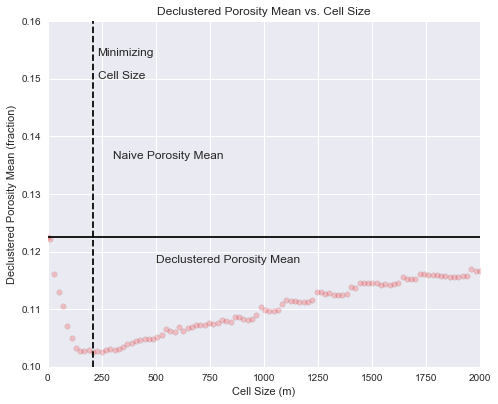

Declustered average of porosity is 0.102519
Confidence interval of original sample's mean porosity is 0.122491 +/- 0.005198. 
 


In [177]:
plt.figure(figsize=(5,4)) 

plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Porosity Mean vs. Cell Size')

por_mean = np.average(df['Porosity'].values)
por_dmean = np.average(df['Porosity'].values,weights=df_subset['Wts'].values)
plt.plot([0,2000],[por_mean,por_mean],color = 'black')
plt.plot([cell_sizes[dmeans==dmeans.min()],cell_sizes[dmeans==dmeans.min()]],[0.10,0.16],color = 'black',linestyle='dashed')
plt.text(300., 0.136, r'Naive Porosity Mean')
plt.text(500., 0.118, r'Declustered Porosity Mean')
plt.text(230., 0.154, r'Minimizing')
plt.text(230., 0.150, r'Cell Size')
plt.ylim(0.10,0.16)
plt.xlim(0,2000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()
plt.savefig('Decluster Cell size(Porosity)_total',dpi=600)

ci_95_por = st.t.interval(0.95, len(df_subset)-1, loc=por_mean, scale=st.sem(df_subset['Porosity'].values))
print("Declustered average of porosity is %f" %(por_dmean))
print("Confidence interval of original sample's mean porosity is %f +/- %f. \n " %(por_mean, ci_95_por[1]-por_mean))



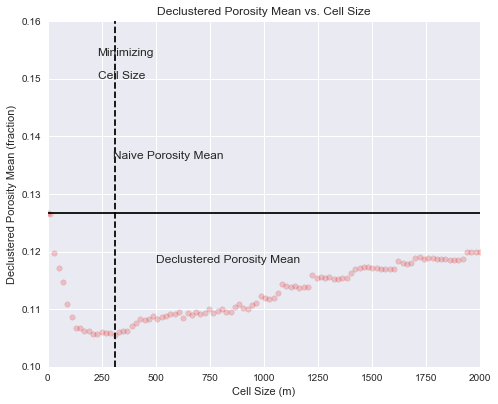

Declustered average of porosity is 0.105497
Confidence interval of original sample's mean porosity is 0.126750 +/- 0.000939. 
 


In [179]:
plt.figure(figsize=(5,4)) 

plt.scatter(cell_sizes_sand,dmeans_sand, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Porosity Mean vs. Cell Size')

por_mean = np.average(df_sand['Porosity'].values)
por_dmean = np.average(df_sand['Porosity'].values,weights=df_sand['Wts'].values)
plt.plot([0,2000],[por_mean,por_mean],color = 'black')
plt.plot([cell_sizes[dmeans_sand==dmeans_sand.min()],cell_sizes[dmeans_sand==dmeans_sand.min()]],[0.10,0.16],color = 'black',linestyle='dashed')
plt.text(300., 0.136, r'Naive Porosity Mean')
plt.text(500., 0.118, r'Declustered Porosity Mean')
plt.text(230., 0.154, r'Minimizing')
plt.text(230., 0.150, r'Cell Size')
plt.ylim(0.10,0.16)
plt.xlim(0,2000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()
plt.savefig('Decluster Cell size(Porosity)_sand',dpi=600)

print("Declustered average of porosity is %f" %(por_dmean))
print("Confidence interval of original sample's mean porosity is %f +/- %f. \n " %(por_mean, ci_95_por[1]-por_mean))



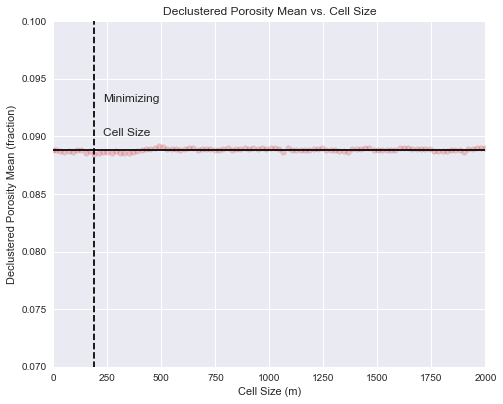

Declustered average of porosity is 0.088474
Confidence interval of original sample's mean porosity is 0.088845 +/- 0.038845. 
 


In [194]:
plt.figure(figsize=(5,4)) 

plt.scatter(cell_sizes_shale,dmeans_shale, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Porosity Mean vs. Cell Size')

por_mean = np.average(df_shale['Porosity'].values)
por_dmean = np.average(df_shale['Porosity'].values,weights=df_shale['Wts'].values)
plt.plot([0,2000],[por_mean,por_mean],color = 'black')
plt.plot([cell_sizes[dmeans_shale==dmeans_shale.min()],cell_sizes[dmeans_shale==dmeans_shale.min()]],[0.0,0.1],color = 'black',linestyle='dashed')
# plt.text(300., 0.09, r'Naive Porosity Mean')
# plt.text(500., 0.09, r'Declustered Porosity Mean')
plt.text(230., 0.093, r'Minimizing')
plt.text(230., 0.09, r'Cell Size')
plt.ylim(0.07,0.1)
plt.xlim(0,2000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()
plt.savefig('Decluster Cell size(Porosity)_shale',dpi=600)

print("Declustered average of porosity is %f" %(por_dmean))
print("Confidence interval of original sample's mean porosity is %f +/- %f. \n " %(por_mean, ci_95_por[1]-por_mean))



# 2. Reservoir Heterogeneity 


1) coefficient of variation
2) Dykstra-Parsons
3) Lorenz coefficient
(by faceis workframe)

### 1) Coeffieicnt of variance

### 2) Dykstra-Parsons

### 3) Lorenz coefficient

# 3. Uncertainty of Porosity, Permeability, Facies proportion, and OOIP


In [197]:
# Declustering (BY ALL AND BY FACIES)

wts_sand, cell_sizes_sand, dmeans_sand = geostats.declus(df_sand,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
wts_shale, cell_sizes_shale, dmeans_shale = geostats.declus(df_shale,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
wts, cell_sizes, dmeans = geostats.declus(df_subset,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)

df_sand['Wts'] = wts_sand  
df_shale['Wts'] = wts_shale
df_subset['Wts'] = wts  

There are 158 data with:
   mean of      0.126750289563 
   min and max  0.079210481 and 0.186311206
   standard dev 0.034889607528 
There are 20 data with:
   mean of      0.088845095 
   min and max  0.078601287 and 0.097991102
   standard dev 0.00620744758609 
There are 178 data with:
   mean of      0.122491278938 
   min and max  0.078601287 and 0.186311206
   standard dev 0.0350448297015 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [223]:
# Bootstraping for Porosity (by faces, decluster), Permeability (by faces, decluster), and facies ratio (decluster)

L = 1000                                   # set the number of realizations
mean_poro_sand = np.zeros(L); stdev_poro_sand = np.zeros(L)    # declare arrays to hold the realizations of the statistics
mean_poro_shale = np.zeros(L); stdev_poro_shale = np.zeros(L)    # declare arrays to hold the realizations of the statistics
mean_perm_sand = np.zeros(L); stdev_perm_sand = np.zeros(L)    # declare arrays to hold the realizations of the statistics
mean_perm_shale = np.zeros(L); stdev_perm_shale = np.zeros(L)    # declare arrays to hold the realizations of the statistics
mean_facies = np.zeros(L); stdev_facies = np.zeros(L)    # declare arrays to hold the realizations of the statistics


for l in range(0, L):                      # loop over realizations
    samples = random.choices(df_sand['Porosity'].values, weights=df_sand['Wts'].values, cum_weights=None, k=L)
    mean_poro_sand[l] = np.average(samples)
    stdev_poro_sand[l] = np.std(samples)

    samples = random.choices(df_shale['Porosity'].values, weights=df_shale['Wts'].values, cum_weights=None, k=L)
    mean_poro_shale[l] = np.average(samples)
    stdev_poro_shale[l] = np.std(samples)    

    samples = random.choices(df_sand['Perm'].values, weights=df_sand['Wts'].values, cum_weights=None, k=L)
    mean_perm_sand[l] = np.average(np.log(samples))
    stdev_perm_sand[l] = np.std(np.log(samples))
    
    samples = random.choices(df_shale['Perm'].values, weights=df_shale['Wts'].values, cum_weights=None, k=L)
    mean_perm_shale[l] = np.average(np.log(samples))
    stdev_perm_shale[l] = np.std(np.log(samples))    

    samples = random.choices(df_subset['Facies'].values, weights=df_subset['Wts'].values, cum_weights=None, k=L)
    mean_facies[l] = np.average(samples)
    stdev_facies[l] = np.std(samples)    
    

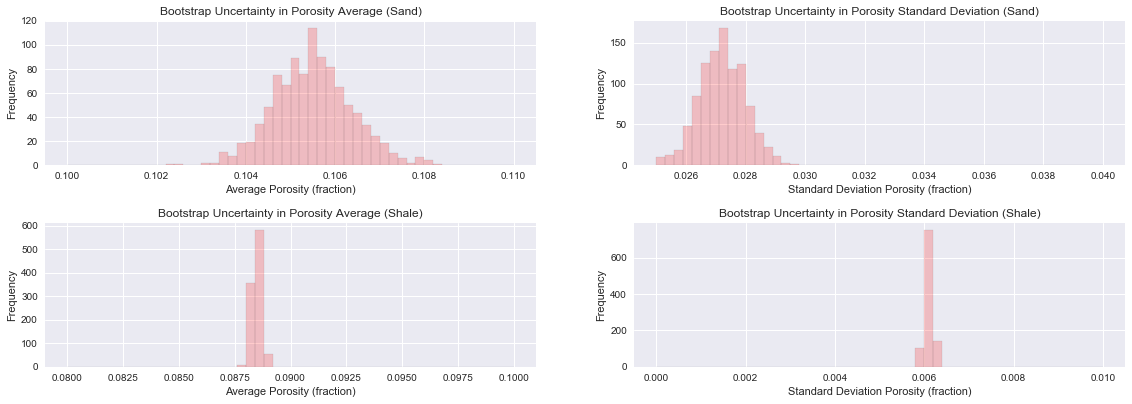

In [237]:
# Porosity visualization
plt.figure(figsize=(5,4)) 
plt.subplot(221)
GSLIB.hist_st(mean_poro_sand,0.1,0.11,False,False,50,None,'Average Porosity (fraction)','Bootstrap Uncertainty in Porosity Average (Sand)')
plt.subplot(222)
GSLIB.hist_st(stdev_poro_sand,0.025,0.04,False,False,50,None,'Standard Deviation Porosity (fraction)','Bootstrap Uncertainty in Porosity Standard Deviation (Sand)')
plt.subplot(223)
GSLIB.hist_st(mean_poro_shale,0.08,0.1,False,False,50,None,'Average Porosity (fraction)','Bootstrap Uncertainty in Porosity Average (Shale)')
plt.subplot(224)
GSLIB.hist_st(stdev_poro_shale,0,0.01,False,False,50,None,'Standard Deviation Porosity (fraction)','Bootstrap Uncertainty in Porosity Standard Deviation (Shale)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.4)
plt.show()   
plt.savefig('Uncertainty of Porosity',dpi=600)


In [232]:
stats.describe(mean_poro_sand)

DescribeResult(nobs=1000, minmax=(0.10220879041, 0.108367740862), mean=0.10549181566731901, variance=7.720566278323944e-07, skewness=0.13386964974395052, kurtosis=0.3202500860294757)

In [233]:
stats.describe(mean_poro_shale)

DescribeResult(nobs=1000, minmax=(0.087866068148000007, 0.089142591339999994), mean=0.088476386372100008, variance=4.0690983789777525e-08, skewness=-0.03280604112862716, kurtosis=-0.19797603908207417)

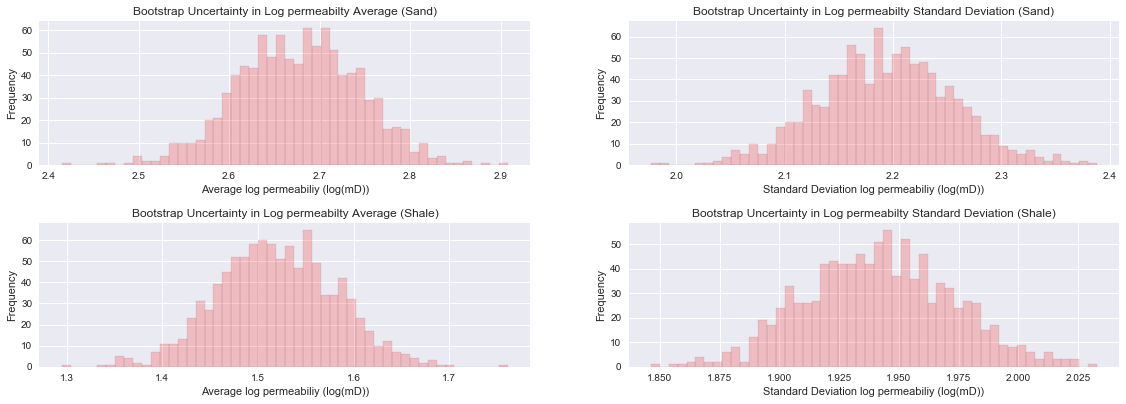

In [236]:
# Permeabiltiy visualization

plt.figure(figsize=(5,4)) 
plt.subplot(221)
GSLIB.hist_st(mean_perm_sand,mean_perm_sand.min(),mean_perm_sand.max(),False,False,50,None,'Average log permeabiliy (log(mD))','Bootstrap Uncertainty in Log permeabilty Average (Sand)')
plt.subplot(222)
GSLIB.hist_st(stdev_perm_sand,stdev_perm_sand.min(),stdev_perm_sand.max(),False,False,50,None,'Standard Deviation log permeabiliy (log(mD))','Bootstrap Uncertainty in Log permeabilty Standard Deviation (Sand)')
plt.subplot(223)
GSLIB.hist_st(mean_perm_shale,mean_perm_shale.min(),mean_perm_shale.max(),False,False,50,None,'Average log permeabiliy (log(mD))','Bootstrap Uncertainty in Log permeabilty Average (Shale)')
plt.subplot(224)
GSLIB.hist_st(stdev_perm_shale,stdev_perm_shale.min(),stdev_perm_shale.max(),False,False,50,None,'Standard Deviation log permeabiliy (log(mD))','Bootstrap Uncertainty in Log permeabilty Standard Deviation (Shale)')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.4)
plt.show()   
plt.savefig('Uncertainty of Permeability',dpi=600)


In [235]:
stats.describe(mean_perm_sand)

DescribeResult(nobs=1000, minmax=(2.4149454804085235, 2.9083239470506985), mean=2.6768690125687211, variance=0.0045862601103457204, skewness=-0.061789445858799606, kurtosis=0.10536998609544934)

In [234]:
stats.describe(mean_perm_shale)

DescribeResult(nobs=1000, minmax=(1.2950140147951406, 1.7613137044567788), mean=1.5197627973047547, variance=0.0038586150296355836, skewness=0.004215344889912077, kurtosis=0.10455373348267827)

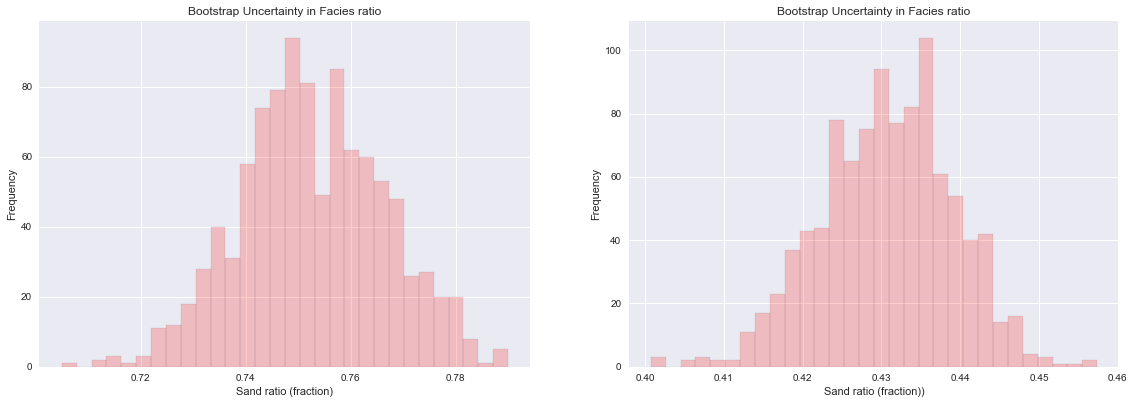

In [258]:
# Facies ratio visualization
plt.figure(figsize=(5,4)) 
plt.subplot(121)
GSLIB.hist_st(mean_facies,mean_facies.min(),mean_facies.max(),False,False,30,None,'Sand ratio (fraction)','Bootstrap Uncertainty in Facies ratio')
plt.subplot(122)
GSLIB.hist_st(stdev_facies,stdev_facies.min(),stdev_facies.max(),False,False,30,None,'Sand ratio (fraction))','Bootstrap Uncertainty in Facies ratio')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.4)
plt.show()   
plt.savefig('Uncertainty of Rock facies',dpi=600)


In [239]:
stats.describe(mean_facies)

DescribeResult(nobs=1000, minmax=(0.70199999999999996, 0.79900000000000004), mean=0.75328300000000004, variance=0.0001978687797797801, skewness=-0.03986244648693236, kurtosis=0.1555086866272144)

In [254]:
# Uncertainty of OOIP
# OOIP=6.2898*A*h*Sw*(poro_sand*ratio_sand+poro_shale*ratio_shale)

L=1000
mean_poro_sand = np.zeros(L);
mean_poro_shale = np.zeros(L);
mean_facies = np.zeros(L);
OOIP = np.zeros(L)

for l in range(0, L):                      # loop over realizations
    samples = random.choices(df_sand['Porosity'].values, weights=df_sand['Wts'].values, cum_weights=None, k=L)
    mean_poro_sand[l] = np.average(samples)
    samples = random.choices(df_shale['Porosity'].values, weights=df_shale['Wts'].values, cum_weights=None, k=L)
    mean_poro_shale[l] = np.average(samples)
    samples = random.choices(df_subset['Facies'].values, weights=df_subset['Wts'].values, cum_weights=None, k=L)
    mean_facies[l] = np.average(samples)

Sw=0.9; h=20; # in meter
Area=1E6; # in (meter)^2
OOIP=6.2898*Sw*h*Area*(mean_poro_sand*mean_facies+mean_poro_shale*(1-mean_facies))

OOIP=OOIP/1E6 # in MMbbls

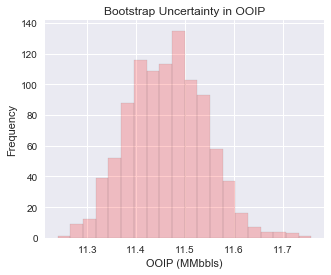

In [257]:
plt.figure(figsize=(5,4)) 
GSLIB.hist_st(OOIP,OOIP.min(),OOIP.max(),False,False,20,None,'OOIP (MMbbls)','Bootstrap Uncertainty in OOIP')
plt.show()   
plt.savefig('Uncertainty of OOIP',dpi=600)


# 4. New 10 wells influence